# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this [link](https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312). Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following [link](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ). 

# Step 1: Prepare the environment 

Use one of the labs which we have practised on with the Amazon Sagemakers where you perform the following steps:
1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".

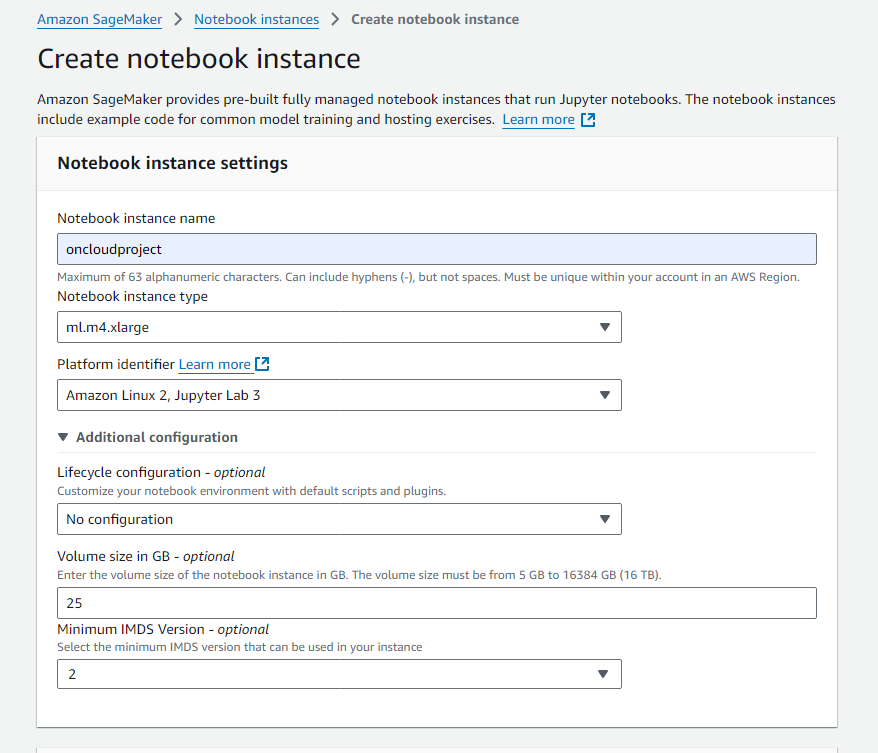

3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.




![alt text](image2.png "Title")

#### Importing Libraries

In [1]:
# import libraries

import warnings, requests, zipfile, io

warnings.simplefilter("ignore")
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split


# Import the necessary libraries
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns



sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Matplotlib is building the font cache; this may take a moment.


#### Importing Dataset

In [ ]:
import pandas as pd

# load the data

df1 = pd.read_csv("./combined_csv_v1.csv")
df2 = pd.read_csv('./combined_csv_v2.csv')


In [ ]:
#checking first 5 data of CSV V1
df1.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Early Morning,DepHourofDay_Evening,DepHourofDay_Morning
0,0,689.0,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
1,0,731.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,0,1199.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,0,1587.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,0,1587.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [15]:
# shape of the data
df1.shape

(1635590, 75)

In [ ]:
#checking first 5 data of CSV V2
df2.head()

,target,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_True
0,0,689.0,21,33,0,54.0,30,0,130.0,0.0,...,False,False,False,False,True,False,False,False,False,False
1,0,731.0,9,39,0,136.0,33,0,54.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0,1199.0,18,33,0,54.0,77,0,68.0,0.0,...,False,False,True,False,False,False,False,False,False,False
3,0,1587.0,16,33,0,54.0,20,0,165.0,0.0,...,False,False,False,False,False,False,False,True,False,False
4,0,1587.0,7,20,0,165.0,33,0,54.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [17]:
# shape of the data
df2.shape

(1635590, 86)

#### Function for classification metrices 

In [ ]:
#fucntion for confusion matrix
def plot_confusion_matrix(test_labels, target_predicted):
    # complete the code here
    cm = confusion_matrix(test_labels, target_predicted)
    # Create a heatmap
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["On-Time", "Delayed"],
        yticklabels=["On-Time", "Delayed"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [3]:
# Function to display the ROC Curve
def plot_roc(y_test, predicted_labels):
    # Determine the false positive rate, true positive rate and thresholds
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_labels)
    
    # Calculate the area under the curve
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    # Plot the ROC
    plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve, AUC = {round(roc_auc,2)}')
    # Plot the line of no discrimination (45 degree angle)
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Function to plot the classification performance metrics
def plot_metrics(y_true, y_pred):    
        
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')  # Use 'macro' or 'weighted' for multiclass
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    
    
    # Print the evaluation metrics
    print('Evaluation Metrics')
    print('------------------')
    # Display metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

### Setting up S3 Bucket

In [5]:
import logging


# import boto3

from botocore.exceptions import ClientError



def create_bucket(bucket_name, region=None):

    """Create an S3 bucket in a specified region


    If a region is not specified, the bucket is created in the S3 default

    region (us-east-1).


    :param bucket_name: Bucket to create

    :param region: String region to create bucket in, e.g., 'us-west-2'

    :return: True if bucket created, else False
    """


    # Create bucket

    try:

        if region is None:

            s3_client = boto3.client("s3")

            s3_client.create_bucket(Bucket=bucket_name)
        else:

            s3_client = boto3.client("s3", region_name=region)

            location = {"LocationConstraint": region}

            s3_client.create_bucket(
                Bucket=bucket_name, CreateBucketConfiguration=location
            )

    except ClientError as e:

        logging.error(e)

        return False

    return True

In [6]:
# Function to check if the bucket exists
def check_bucket_exists(bucket_name):
    s3 = boto3.client("s3")
    try:
        s3.head_bucket(Bucket=bucket_name)
        print(f"Bucket '{bucket_name}' already exists.")
        return True
    except ClientError as e:
        # If a 404 error is raised, the bucket does not exist
        if e.response["Error"]["Code"] == "404":
            print(f"Bucket '{bucket_name}' does not exist.")
            return False
        else:
            # If there's any other error, raise it
            raise

##### create an S3 bucket

In [9]:
# create an S3 bucket

# set the s3 bucket name
bucket = "u3268781-tshering-gyeltshen"

# check if bucket exists
bucket_exists = check_bucket_exists(bucket)

# Create the bucket if it doesn't exist
if not bucket_exists:
    create_bucket(bucket)

Bucket 'u3268781-tshering-gyeltshen' does not exist.


In [ ]:
# function uploading data to aws s3

prefix = "dsts-final"

s3_resource = boto3.Session().resource("s3")


def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    print(s3_resource.Bucket(bucket))
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(
        Body=csv_buffer.getvalue()
    )

In [ ]:
import io
import numpy as np
import sagemaker.amazon.common as smac


# function to prepare data for sagemaker training


def prepare_data(dataframe):
    vectors = dataframe.drop(columns=["target"]).values.astype("float32")
    labels = dataframe["target"].values.astype("float32")
    buf = io.BytesIO()
    smac.write_numpy_to_dense_tensor(buf, vectors, labels)
    buf.seek(0)

    return buf

In [ ]:
import boto3
import os


# function to upload prepared training data to s3
def upload_s3_buf(buf, bucket, prefix, type):
    
    boto3.resource("s3").Bucket(bucket).Object(
        os.path.join(prefix, type)
    ).upload_fileobj(buf)
    s3_data_path = "s3://{}/{}/{}".format(bucket, prefix, type)
    print("uploaded {} data to location: {}".format(type, s3_data_path))
    return s3_data_path

# Step 2: Build and evaluate simple models for Combined CSV V1

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.

In [20]:
# split the data

train, test_and_validate = train_test_split(
    df1, test_size=0.3, random_state=42, stratify=df1["target"]
)
test, validate = train_test_split(
    test_and_validate,
    test_size=0.5,
    random_state=42,
    stratify=test_and_validate["target"],
)

In [21]:
# Examine the shape of the three datasets
print("Train",train.shape)
print("Test",test.shape)
print("Validate",validate.shape)

Train (1144913, 75)
Test (245338, 75)
Validate (245339, 75)


In [19]:
# Check the distribution of the classes
print(train['target'].value_counts())
print(test['target'].value_counts())
print(validate['target'].value_counts())
print()
# As percentages
print(train['target'].value_counts(1))
print(test['target'].value_counts(1))
print(validate['target'].value_counts(1))

0    913237
1    231676
Name: target, dtype: int64
0    195693
1     49645
Name: target, dtype: int64
0    195694
1     49645
Name: target, dtype: int64

0    0.797648
1    0.202352
Name: target, dtype: float64
0    0.797647
1    0.202353
Name: target, dtype: float64
0    0.797647
1    0.202353
Name: target, dtype: float64


In [20]:
# set the names of the csv files
train_file = "data_train.csv"
test_file = "data_test.csv"
validate_file = "data_validate.csv"

Uploading Combined CSV 1 data to S3 Bucket

In [21]:
# prepare train data
train_buf = prepare_data(train)

# upload train data
s3_train_data = upload_s3_buf(train_buf, bucket, prefix, "train")

uploaded train data to location: s3://u3268781-tshering-gyeltshen/dsts-final/train


In [22]:
# prepare validation data
validate_buf = prepare_data(validate)

# upload validation data
s3_validate_data = upload_s3_buf(validate_buf, bucket, prefix, "validate")

uploaded validate data to location: s3://u3268781-tshering-gyeltshen/dsts-final/validate


In [23]:
output_location = "s3://{}/{}/output".format(bucket, prefix)
print("training artifacts will be uploaded to: {}".format(output_location))

training artifacts will be uploaded to: s3://u3268781-tshering-gyeltshen/dsts-final/output


In [ ]:
# URI for Amazon SageMaker's "linear-learner" algorithm container
from sagemaker.image_uris import retrieve

container = retrieve("linear-learner", boto3.Session().region_name)

Binary Classification Model Training on SageMaker using Linear Learner Algorithm

In [27]:
import boto3

sess = sagemaker.Session()
role = sagemaker.get_execution_role()

linear = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type="ml.p3.2xlarge",
    output_path=output_location,
    sagemaker_session=sess,
)
linear.set_hyperparameters(feature_dim=74, predictor_type="binary_classifier")

linear.fit({"train": s3_train_data, "validation": s3_validate_data})

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-11-02-10-50-01-767


2024-11-02 10:50:02 Starting - Starting the training job
2024-11-02 10:50:02 Pending - Training job waiting for capacity......
2024-11-02 10:51:00 Pending - Preparing the instances for training......
2024-11-02 10:51:50 Downloading - Downloading input data...
2024-11-02 10:52:20 Downloading - Downloading the training image......
2024-11-02 10:53:26 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sat Nov  2 10:53:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr

Deploying Linear Learner Model on SageMaker

In [29]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_predictor = linear.deploy(
    initial_instance_count=1,
    instance_type="ml.p3.2xlarge",
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer(),
)

INFO:sagemaker:Creating model with name: linear-learner-2024-11-02-11-08-36-976
INFO:sagemaker:Creating endpoint-config with name linear-learner-2024-11-02-11-08-36-976
INFO:sagemaker:Creating endpoint with name linear-learner-2024-11-02-11-08-36-976


--------!

Generating Predictions for Test Data

In [30]:
predictions = []
for i in range(0, test.shape[0]):
    result = linear_predictor.predict(test.iloc[i, 1:].to_numpy(dtype=np.float32))
    # print(result)
    predictions += [r["predicted_label"] for r in result["predictions"]]

predictions = np.array(predictions)
# print(predictions)

#### Evaluation For Combined CSV V1

Confusion Matrix for Combined CSV v1


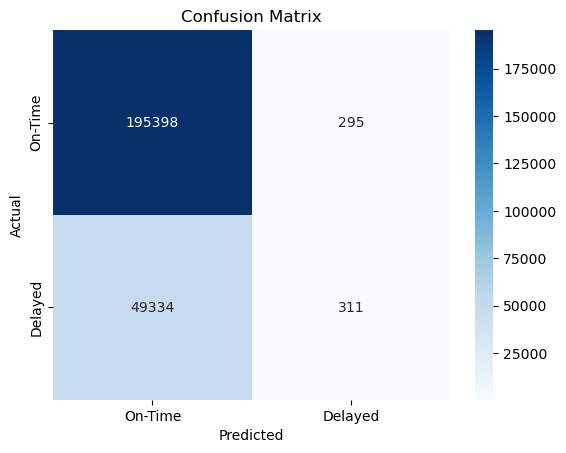

In [31]:
# Confusion matrix for test data

print("Confusion Matrix for Combined CSV v1")
plot_confusion_matrix(test.iloc[:, 0], predictions)

The confusion matrix reveals that the model correctly classified 195,398 on-time flights and 311 delayed flights. There were 295 on-time flights incorrectly classified as delayed (false positives) and 49,334 delayed flights incorrectly classified as on-time (false negatives). This distribution indicates that while the model is highly accurate in predicting on-time flights, it struggles significantly with detecting delayed flights, as shown by the high number of false negatives. This suggests a need for adjustments to improve the model's ability to identify delayed flights accurately.

ROC for Combined CSV v1


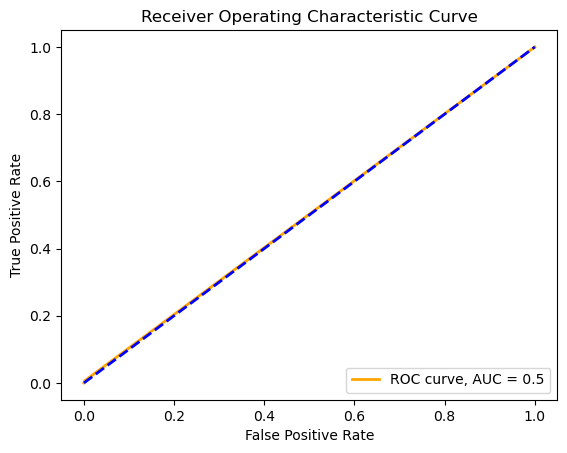

In [ ]:
# ROC Curve for test data
print("ROC for Combined CSV v1")
plot_roc(test.iloc[:, 0], predictions)

In [33]:
# Plot the performance metrics
print("Performance Metrices for Combined CSV v1")
plot_metrics(test.iloc[:, 0], predictions)

Performance Metrices for Combined CSV v1
Evaluation Metrics
------------------
Accuracy: 0.7977117283095159
Precision: 0.5132013201320133
Recall: 0.006264477792325511
F1 Score: 0.012377863127101948


In [34]:
# classification report
from sklearn.metrics import classification_report

# Classification report for test data
print("Classification Report on Test Data")
print(classification_report(test.iloc[:, 0], predictions))

Classification Report on Test Data
              precision    recall  f1-score   support

           0       0.80      1.00      0.89    195693
           1       0.51      0.01      0.01     49645

    accuracy                           0.80    245338
   macro avg       0.66      0.50      0.45    245338
weighted avg       0.74      0.80      0.71    245338



### Report the performance metrics

This linear learner model with only flight data i.e. Combined CSV V1 achieved an accuracy of approximately 0.798. However, this high accuracy is misleading due to the significant class imbalance, where on-time flights constitute the majority of the data. The model’s recall is extremely low at 0.006, indicating that it correctly identifies very few delayed flights, making it ineffective for the primary goal of delay prediction. The F1 score of 0.012 reflects this poor balance between precision and recall, and the AUC of 0.5 suggests that the model performs no better than random guessing in distinguishing between on-time and delayed flights.

This model inadequate for this task. Despite its high accuracy, the low recall and F1 score highlight its inability to detect delays effectively. This setup is unsuitable for real-world deployment in a system that aims to notify customers of potential delays, as it fails to capture the minority class (delayed flights) accurately.

# Step 2: Build and evaluate simple models for Combined CSV V2

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.

In [15]:
# split the data

train2, test_and_validate2 = train_test_split(
    df2, test_size=0.3, random_state=42, stratify=df2["target"]
)
test2, validate2 = train_test_split(
    test_and_validate2,
    test_size=0.5,
    random_state=42,
    stratify=test_and_validate2["target"],
)

In [16]:
# Examine the shape of the three datasets
print("Train",train2.shape)
print("Test",test2.shape)
print("Validate",validate2.shape)

Train (1144913, 86)
Test (245338, 86)
Validate (245339, 86)


In [17]:
# Check the distribution of the classes
print(train2['target'].value_counts())
print(test2['target'].value_counts())
print(validate2['target'].value_counts())
print()
# As percentages
print(train2['target'].value_counts(1))
print(test2['target'].value_counts(1))
print(validate2['target'].value_counts(1))

0    913237
1    231676
Name: target, dtype: int64
0    195693
1     49645
Name: target, dtype: int64
0    195694
1     49645
Name: target, dtype: int64

0    0.797648
1    0.202352
Name: target, dtype: float64
0    0.797647
1    0.202353
Name: target, dtype: float64
0    0.797647
1    0.202353
Name: target, dtype: float64


In [18]:
# set the names of the csv files
train_file2 = "data_train2.csv"
test_file2 = "data_test2.csv"
validate_file2 = "data_validate2.csv"

Uploading Combined CSV 2 data to S3 Bucket

In [19]:
# prepare train data
train_buf2 = prepare_data(train2)

# upload train data
s3_train_data2 = upload_s3_buf(train_buf2, bucket, prefix, "train")

uploaded train data to location: s3://u3268781-tshering-gyeltshen/dsts-final/train


In [20]:
# prepare validation data
validate_buf2 = prepare_data(validate2)

# upload validation data
s3_validate_data2 = upload_s3_buf(validate_buf2, bucket, prefix, "validate")

uploaded validate data to location: s3://u3268781-tshering-gyeltshen/dsts-final/validate


In [21]:
output_location = "s3://{}/{}/output".format(bucket, prefix)
print("training artifacts will be uploaded to: {}".format(output_location))

training artifacts will be uploaded to: s3://u3268781-tshering-gyeltshen/dsts-final/output


In [ ]:
# URI for Amazon SageMaker's "linear-learner" algorithm container
from sagemaker.image_uris import retrieve

container = retrieve("linear-learner", boto3.Session().region_name)

Binary Classification Model Training on SageMaker using Linear Learner Algorithm

In [23]:
import boto3

sess = sagemaker.Session()
role = sagemaker.get_execution_role()

linear = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type="ml.p3.2xlarge",
    output_path=output_location,
    sagemaker_session=sess,
)
linear.set_hyperparameters(feature_dim=85, predictor_type="binary_classifier")

linear.fit({"train": s3_train_data2, "validation": s3_validate_data2})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-11-02-13-44-44-688


2024-11-02 13:44:45 Starting - Starting the training job
2024-11-02 13:44:45 Pending - Training job waiting for capacity......
2024-11-02 13:45:36 Pending - Preparing the instances for training...
2024-11-02 13:46:20 Downloading - Downloading input data...
2024-11-02 13:46:50 Downloading - Downloading the training image.........
2024-11-02 13:47:56 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sat Nov  2 13:48:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr.

Deploying Linear Learner Model on SageMaker for Real-Time Predictions

In [24]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_predictor = linear.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge",
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer(),
)

INFO:sagemaker:Creating model with name: linear-learner-2024-11-02-14-01-14-072
INFO:sagemaker:Creating endpoint-config with name linear-learner-2024-11-02-14-01-14-072
INFO:sagemaker:Creating endpoint with name linear-learner-2024-11-02-14-01-14-072


--------!

Generating Predictions for Test Data using Deployed SageMaker Linear Learner Model

In [25]:
predictions2 = []
for i in range(0, test2.shape[0]):
    result = linear_predictor.predict(test2.iloc[i, 1:].to_numpy(dtype=np.float32))
    # print(result)
    predictions2 += [r["predicted_label"] for r in result["predictions"]]

predictions2 = np.array(predictions2)
# print(predictions)

#### Evaluation For Combined CSV V1

Confusion Matrix for Combined CSV v2


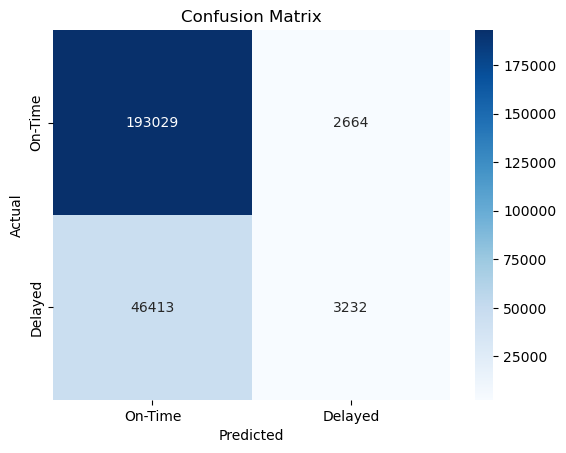

In [26]:
# Confusion matrix for test data

print("Confusion Matrix for Combined CSV v2")
plot_confusion_matrix(test2.iloc[:, 0], predictions2)

The confusion matrix shows that the model correctly classified 193,029 on-time flights and 3,232 delayed flights. However, there are 2,664 on-time flights that were incorrectly classified as delayed (false positives) and 46,413 delayed flights that were incorrectly classified as on-time (false negatives). The model has a strong tendency to predict on-time flights correctly, but it misses a significant number of delayed flights, as seen in the high count of false negatives. This distribution suggests that the model is effective in identifying on-time flights but may need improvement in detecting delayed flights more accurately.

ROC for Combined CSV v2


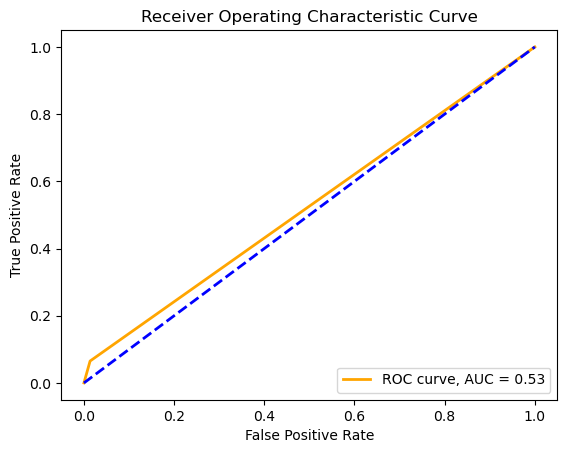

In [ ]:
# ROC Curve for test data
print("ROC for Combined CSV v2")
plot_roc(test2.iloc[:, 0], predictions2)

In [28]:
# Plot the performance metrics
print("Performance Metrices for Combined CSV v2")
plot_metrics(test2.iloc[:, 0], predictions2)

Performance Metrices for Combined CSV v2
Evaluation Metrics
------------------
Accuracy: 0.7999616855114169
Precision: 0.5481682496607869
Recall: 0.06510222580320274
F1 Score: 0.11638249221295979


In [29]:
# classification report
from sklearn.metrics import classification_report

# Classification report for test data
print("Classification Report on Test Data")
print(classification_report(test2.iloc[:, 0], predictions2))

Classification Report on Test Data
              precision    recall  f1-score   support

           0       0.81      0.99      0.89    195693
           1       0.55      0.07      0.12     49645

    accuracy                           0.80    245338
   macro avg       0.68      0.53      0.50    245338
weighted avg       0.75      0.80      0.73    245338



### Report the performance metrics

With this additional information in Combined CVS V2, the linear model achieved a slight increase in recall, reaching 0.065, which indicates a modest improvement in identifying delayed flights. The F1 score rose to 0.116, suggesting a somewhat better balance between precision and recall. However, the AUC only improved marginally to 0.53, which means that the model’s ability to distinguish between on-time and delayed flights remains limited.

While these metrics show minor improvements, they are still far from adequate for delay prediction. The model’s low recall and limited class discrimination suggest that the linear learner does not fully leverage the additional weather variables. Overall, adding weather data enhances performance slightly, but the linear learner remains insufficient for accurately identifying delayed flights.

# Step 3: Build and evaluate ensembe models for Combined CSV V1

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 
6. write down your observation on the difference between the performance of using the simple and ensemble models.
Note: You are required to perform the above steps on the two combined datasets separatey.

In [ ]:
#Get copy of CSV V1
df1 = df1.replace({True: 1, False: 0})

In [54]:
df1.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Early Morning,DepHourofDay_Evening,DepHourofDay_Morning
0,0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [55]:
# split the data

train, test_and_validate = train_test_split(
    df1, test_size=0.3, random_state=42, stratify=df1["target"]
)
test, validate = train_test_split(
    test_and_validate,
    test_size=0.5,
    random_state=42,
    stratify=test_and_validate["target"],
)

In [56]:
# Examine the shape of the three datasets
print("Train",train.shape)
print("Test",test.shape)
print("Validate",validate.shape)

Train (1144913, 75)
Test (245338, 75)
Validate (245339, 75)


In [57]:
# Check the distribution of the classes
print(train['target'].value_counts())
print(test['target'].value_counts())
print(validate['target'].value_counts())
print()
# As percentages
print(train['target'].value_counts(1))
print(test['target'].value_counts(1))
print(validate['target'].value_counts(1))

0    913237
1    231676
Name: target, dtype: int64
0    195693
1     49645
Name: target, dtype: int64
0    195694
1     49645
Name: target, dtype: int64

0    0.797648
1    0.202352
Name: target, dtype: float64
0    0.797647
1    0.202353
Name: target, dtype: float64
0    0.797647
1    0.202353
Name: target, dtype: float64


In [58]:
 # set the names of the csv files
train_file = "data_v1_train.csv"
test_file = "data_v1_test.csv"
validate_file = "data_v1_validate.csv"
# Initialise a connection to the S3 bucket using boto3
s3_resource = boto3.Session().resource('s3')

Uploading Combined CSV 1 data to S3 Bucket

In [59]:
upload_s3_csv(train_file, "train", train)
upload_s3_csv(test_file, "test", test)
upload_s3_csv(validate_file, "validate", validate)

s3.Bucket(name='u3268781-tshering-gyeltshen-dsts')
s3.Bucket(name='u3268781-tshering-gyeltshen-dsts')
s3.Bucket(name='u3268781-tshering-gyeltshen-dsts')


In [ ]:
# URI for Amazon SageMaker's "XGBoost" algorithm container
import boto3
from sagemaker.image_uris import retrieve

container = retrieve("xgboost", "us-east-1", version="1.0-1")

In [ ]:
# setting Hyperparameter
hyperparams = {"num_round": "42", "eval_metric": "auc", "objective": "binary:logistic"}

Setting Up XGBoost Model Training on SageMaker

In [62]:
import sagemaker

session = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))

s3_output_location = "s3://{}/{}/output/".format(bucket, prefix)
xgb_model = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path=s3_output_location,
    hyperparameters=hyperparams,
    sagemaker_session=session,
)

Configuring S3 Data Channels for Training and Validation in SageMaker

In [63]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}


Starting XGBoost Model Training on SageMaker

In [64]:
xgb_model.fit(inputs=data_channels, logs=False)


2024-11-02 18:12:38 Starting - Starting the training job..
2024-11-02 18:12:53 Starting - Preparing the instances for training....
2024-11-02 18:13:19 Downloading - Downloading input data......
2024-11-02 18:13:54 Downloading - Downloading the training image.........
2024-11-02 18:14:45 Training - Training image download completed. Training in progress....................
2024-11-02 18:16:26 Uploading - Uploading generated training model.
2024-11-02 18:16:39 Completed - Training job completed


Deploying Trained XGBoost Model on SageMaker for Real-Time Inference

In [65]:
xgb_predictor = xgb_model.deploy(
    initial_instance_count=1,
    serializer=sagemaker.serializers.CSVSerializer(),
    instance_type="ml.c5.2xlarge",
)

-----!

In [ ]:
# Preparing Batch Input and Output Locations in S3 for SageMaker Batch Transform
batch_X = test.iloc[:, 1:]

batch_X_file = 'batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket, prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket, prefix, batch_X_file)


s3.Bucket(name='u3268781-tshering-gyeltshen-dsts')


Configuring Transformer for XGBoost Batch Inference on SageMaker with MultiRecord Strategy

In [67]:
xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.c5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)




Running Batch Transform Job for XGBoost Model on SageMaker with CSV Input Data

In [68]:
xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

..............................
[2024-11-02:18:24:41:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-02:18:24:41:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-02:18:24:41:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-11-02 18:24:41 +0000] [27] [INFO] Starting guni

In [74]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=['class'])

In [ ]:

# Retrieving and Reading Batch Transform Output from S3 for Predicted Classes
def binary_convert(x):
    threshold = 0.3
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)

print(target_predicted_binary.head(5))
test.head(5)

0    0
1    0
2    1
3    1
4    1
Name: class, dtype: int64


,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Early Morning,DepHourofDay_Evening,DepHourofDay_Morning
1605305,0,862.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1625864,0,1947.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
382659,0,967.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
916498,0,337.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
979204,1,1379.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [83]:
# Display a sample of the test labels
test_labels = test.iloc[:,0]
test_labels.head()

1605305    0
1625864    0
382659     0
916498     0
979204     1
Name: target, dtype: int64

#### Evaluation For Combined CSV V1

Performance Metrices for Combined CSV v1


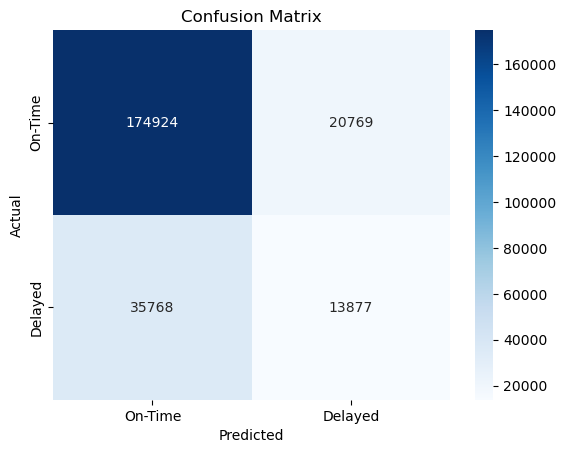

In [85]:
# Plot the confusion matrix on the test set
print("Performance Metrices for Combined CSV v1")
plot_confusion_matrix(test_labels, target_predicted_binary)

The confusion matrix for this model shows that it correctly classified 174,924 flights as on-time and 13,877 flights as delayed. There are, however, 20,769 cases where on-time flights were incorrectly classified as delayed (false positives) and 35,768 cases where delayed flights were incorrectly classified as on-time (false negatives). The model demonstrates an ability to capture both on-time and delayed flights but still shows a notable amount of misclassification in both categories, with a larger count in false negatives than false positives. This distribution highlights areas where the model could potentially improve in accurately distinguishing delayed flights from on-time ones.

Performance Metrices for Combined CSV v1


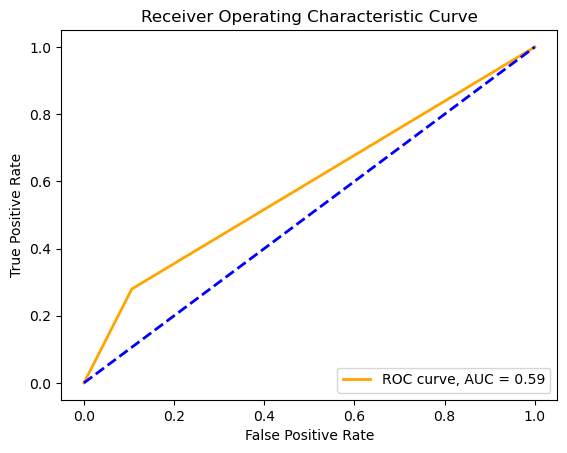

In [86]:
# Plot the ROC curve on the test set
print("Performance Metrices for Combined CSV v1")
plot_roc(test_labels, target_predicted_binary)

In [87]:
# Plot the performance metrics
print("Performance Metrices for Combined CSV v1")
plot_metrics(test_labels, target_predicted_binary)

Performance Metrices for Combined CSV v1
Evaluation Metrics
------------------
Accuracy: 0.7695546552103628
Precision: 0.4005368585118051
Recall: 0.279524624836338
F1 Score: 0.32926409699730697


In [88]:
# classification report
from sklearn.metrics import classification_report

# Classification report for test data
print("Classification Report on Test Data")
print(classification_report(test_labels, target_predicted_binary))

Classification Report on Test Data
              precision    recall  f1-score   support

           0       0.83      0.89      0.86    195693
           1       0.40      0.28      0.33     49645

    accuracy                           0.77    245338
   macro avg       0.62      0.59      0.60    245338
weighted avg       0.74      0.77      0.75    245338



### Report the performance metrics

Switching to an ensemble model (XGBoost) with only Combined_CSV_V1 data resulted in a substantial improvement. The recall increased to 0.279, showing that the model is now able to identify a much larger portion of delayed flights. The F1 score improved to 0.329, reflecting a better balance between precision and recall, and the AUC rose to 0.59, indicating that XGBoost has a stronger ability to distinguish between on-time and delayed flights compared to the linear learner. These improvements suggest that XGBoost can capture more complex patterns in the data that were missed by the linear model.

This model represents a meaningful advancement over the linear model, as XGBoost’s increased recall and F1 score make it more capable of predicting delays. While there is still room for improvement, particularly in recall, this case demonstrates that ensemble models are more effective for handling imbalanced classes in delay prediction tasks.

# Step 3: Build and evaluate ensembe models for Combined CSV V2

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 
6. write down your observation on the difference between the performance of using the simple and ensemble models.
Note: You are required to perform the above steps on the two combined datasets separatey.

In [ ]:
#Get copy of CSV V2
df2 = df2.replace({True: 1, False: 0})

In [19]:
df2.head()

,target,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_True
0,0,689.0,21,33,0,54.0,30,0,130.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0,731.0,9,39,0,136.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,1199.0,18,33,0,54.0,77,0,68.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,0,1587.0,16,33,0,54.0,20,0,165.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,0,1587.0,7,20,0,165.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df2.shape

(1635590, 86)

In [21]:
# split the data

train2, test_and_validate2 = train_test_split(
    df2, test_size=0.3, random_state=42, stratify=df2["target"]
)
test2, validate2 = train_test_split(
    test_and_validate2,
    test_size=0.5,
    random_state=42,
    stratify=test_and_validate2["target"],
)

In [22]:
# Examine the shape of the three datasets
print("Train",train2.shape)
print("Test",test2.shape)
print("Validate",validate2.shape)

Train (1144913, 86)
Test (245338, 86)
Validate (245339, 86)


In [23]:
# Check the distribution of the classes
print(train2['target'].value_counts())
print(test2['target'].value_counts())
print(validate2['target'].value_counts())
print()
# As percentages
print(train2['target'].value_counts(1))
print(test2['target'].value_counts(1))
print(validate2['target'].value_counts(1))

0    913237
1    231676
Name: target, dtype: int64
0    195693
1     49645
Name: target, dtype: int64
0    195694
1     49645
Name: target, dtype: int64

0    0.797648
1    0.202352
Name: target, dtype: float64
0    0.797647
1    0.202353
Name: target, dtype: float64
0    0.797647
1    0.202353
Name: target, dtype: float64


In [24]:
# set the names of the csv files
train_file2 = "data_train2.csv"
test_file2 = "data_test2.csv"
validate_file2 = "data_validate2.csv"

In [25]:
# Initialise a connection to the S3 bucket using boto3
s3_resource = boto3.Session().resource('s3')

Uploading Combined CSV 1 data to S3 Bucket

In [27]:

upload_s3_csv(train_file2, "train", train2)
upload_s3_csv(test_file2, "test", test2)
upload_s3_csv(validate_file2, "validate", validate2)


s3.Bucket(name='u3268781-tshering-gyeltshen')
s3.Bucket(name='u3268781-tshering-gyeltshen')
s3.Bucket(name='u3268781-tshering-gyeltshen')


In [ ]:
# URI for Amazon SageMaker's "XGBoost" algorithm container
import boto3
from sagemaker.image_uris import retrieve

container = retrieve("xgboost", "us-east-1", version="1.0-1")

In [ ]:
# setting Hyperparameter
hyperparams = {"num_round": "42", "eval_metric": "auc", "objective": "binary:logistic"}

Setting Up XGBoost Model Training on SageMaker

In [30]:
import sagemaker

session = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))

s3_output_location = "s3://{}/{}/output/".format(bucket, prefix)
xgb_model = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path=s3_output_location,
    hyperparameters=hyperparams,
    sagemaker_session=session,
)

Configuring S3 Data Channels for Training and Validation in SageMaker

In [31]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file2),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file2),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

Starting XGBoost Model Training on SageMaker

In [32]:
xgb_model.fit(inputs=data_channels, logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-02-23-10-02-344



2024-11-02 23:10:03 Starting - Starting the training job..
2024-11-02 23:10:18 Starting - Preparing the instances for training.....
2024-11-02 23:10:49 Downloading - Downloading input data......
2024-11-02 23:11:24 Downloading - Downloading the training image........
2024-11-02 23:12:10 Training - Training image download completed. Training in progress.......................
2024-11-02 23:14:06 Uploading - Uploading generated training model.
2024-11-02 23:14:19 Completed - Training job completed


Deploying Trained XGBoost Model on SageMaker for Real-Time Inference

In [33]:
xgb_predictor = xgb_model.deploy(
    initial_instance_count=1,
    serializer=sagemaker.serializers.CSVSerializer(),
    instance_type="ml.c5.2xlarge",
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-02-23-14-20-257
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-11-02-23-14-20-257
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-11-02-23-14-20-257


------!

In [34]:
batch_X = test2.iloc[:, 1:]

batch_X_file = 'batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket, prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket, prefix, batch_X_file)

s3.Bucket(name='u3268781-tshering-gyeltshen')


Running Batch Transform Job for XGBoost Model on SageMaker with CSV Input Data

In [35]:
xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.c5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)



INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-02-23-17-55-949


Running Batch Transform Job for XGBoost Model on SageMaker with CSV Input Data

In [36]:
xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-02-23-17-56-615


................................[2024-11-02:23:23:14:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-02:23:23:14:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-02:23:23:14:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-11-02 23:23:14 +0000] [27] [INFO] Starting gun

In [37]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=['class'])

In [ ]:
# Retrieving and Reading Batch Transform Output from S3 for Predicted Classes
def binary_convert(x):
    threshold = 0.3
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)

print(target_predicted_binary.head(5))
test2.head(5)

0    0
1    0
2    0
3    0
4    1
Name: class, dtype: int64


,target,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_True
1605305,0,862.0,13,42,0,256.0,56,0,242.0,0.0,...,0,0,1,0,0,0,0,0,0,0
1625864,0,1947.0,13,26,8,264.0,32,0,213.0,0.0,...,0,0,0,0,0,1,0,0,0,0
382659,0,967.0,7,47,0,-12.0,85,0,112.0,0.0,...,0,0,0,0,0,0,0,0,1,0
916498,0,337.0,17,44,0,164.0,42,0,212.0,0.0,...,1,0,0,0,0,1,0,0,0,0
979204,1,1379.0,21,32,0,99.0,38,112,136.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [40]:
# Display a sample of the test labels
test_labels = test2.iloc[:,0]
test_labels.head()

1605305    0
1625864    0
382659     0
916498     0
979204     1
Name: target, dtype: int64

#### Evaluation for CSV V2

Performance Metrices for Combined CSV v2


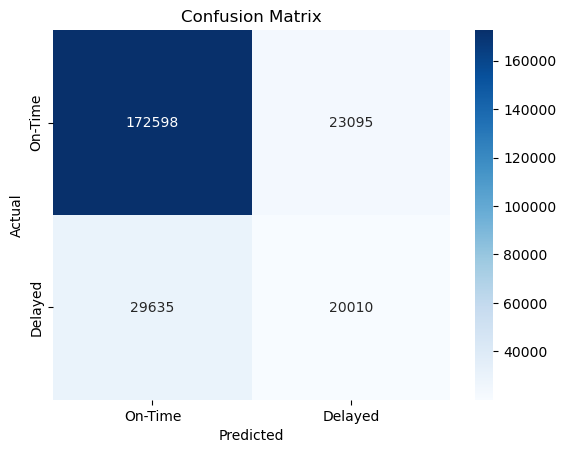

In [41]:
# Plot the confusion matrix on the test set
print("Performance Metrices for Combined CSV v2")
plot_confusion_matrix(test_labels, target_predicted_binary)

The confusion matrix for the this model shows that it correctly classified 172,598 on-time flights and 20,010 delayed flights. However, it also incorrectly classified 23,095 on-time flights as delayed and missed 29,635 delayed flights by predicting them as on-time. While the model captures a significant number of delayed flights (20,010), it still misses a substantial portion, as indicated by the high number of false negatives (29,635). This distribution suggests that, although the model has improved in identifying delays, there is room for further enhancement to reduce both false positives and false negatives for better predictive accuracy.

Performance Metrices for Combined CSV v2


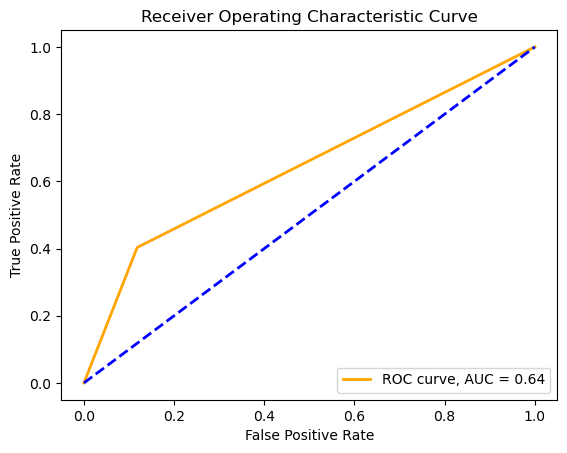

In [42]:
# Plot the ROC curve on the test set
print("Performance Metrices for Combined CSV v2")
plot_roc(test_labels, target_predicted_binary)

In [43]:
# Plot the performance metrics
print("Performance Metrices for Combined CSV v2")
plot_metrics(test_labels, target_predicted_binary)

Performance Metrices for Combined CSV v2
Evaluation Metrics
------------------
Accuracy: 0.7850720230865174
Precision: 0.464215288249623
Recall: 0.40306173834222986
F1 Score: 0.4314824797843666


In [44]:
# classification report
from sklearn.metrics import classification_report

# Classification report for test data
print("Classification Report on Test Data")
print(classification_report(test_labels, target_predicted_binary))

Classification Report on Test Data
              precision    recall  f1-score   support

           0       0.85      0.88      0.87    195693
           1       0.46      0.40      0.43     49645

    accuracy                           0.79    245338
   macro avg       0.66      0.64      0.65    245338
weighted avg       0.77      0.79      0.78    245338



### Report the performance metrics

The final model, XGBoost with both flight and weather data i.e. Combined_CSV_V2, yielded the best performance across all cases. The model achieved a recall of 0.403, indicating that it correctly identifies a substantial portion of delayed flights. The F1 score reached 0.431, showing a stronger balance between precision and recall than in any other case. Additionally, the AUC improved to 0.64, reflecting the model’s enhanced ability to distinguish between on-time and delayed flights. This improvement is likely due to XGBoost’s capability to leverage the additional weather features, capturing the non-linear interactions between flight and weather variables that contribute to delays.

This model proves to be the most effective for predicting flight delays, as it combines high recall, F1 score, and AUC, making it the best model for accurately notifying customers of potential delays. XGBoost’s ability to utilize complex feature interactions results in a more reliable delay prediction model, aligning well with the objective of enhancing customer experience by providing timely delay notifications.

## 6. write down your observation on the difference between the performance of using the simple and ensemble models.

The performance differences between the simple linear learner and the ensemble models, particularly XGBoost, are quite stark. In the case of the linear model, while it initially appeared to perform well with a high accuracy (around 0.8), this accuracy was misleading due to the model’s bias toward the majority class, which was “on-time” flights. The linear model struggled with recall, barely detecting any delayed flights, which resulted in an extremely low recall score (0.006 in the initial model). This made it ineffective for the core purpose of delay prediction, as it was missing almost all actual delays. In this scenario, accuracy alone was not a meaningful indicator of performance, given the highly imbalanced nature of the dataset.

The ensemble model, XGBoost, on the other hand, brought significant improvements across key metrics, particularly recall. With XGBoost, recall improved to around 0.403 when weather variables were included, showing that the model was capturing a much larger portion of actual delays. This improvement in recall is crucial for the intended application, where the goal is to accurately predict delays and provide timely information to customers. Higher recall means fewer delayed flights are missed, which is essential for a delay prediction system where identifying delays accurately is more important than simply achieving high overall accuracy.

Additionally, the AUC (Area Under the ROC Curve) improved noticeably with XGBoost, reaching 0.64 compared to the linear model’s AUC of 0.5, which indicated random guessing. This improvement in AUC suggests that XGBoost was better at distinguishing between delayed and on-time flights. The increase in AUC reflects the model's ability to leverage more complex interactions between features, such as those introduced by weather variables. Ensemble methods like XGBoost are known for handling non-linear relationships effectively, and in this case, the model was able to use the additional weather features to improve its understanding of delay patterns.

While the ensemble model’s overall accuracy decreased slightly, this is actually beneficial in this context. The decrease in accuracy reflects a shift toward a more balanced prediction, where both delayed and on-time flights are considered, rather than favoring the majority class. The ensemble model’s higher recall and F1 score indicate that it has a better balance between precision and recall, making it far more reliable for delay prediction than the linear model. In summary, XGBoost outperformed the linear model by identifying more delayed flights, achieving a better balance between the classes, and effectively incorporating additional features, making it the preferable choice for this task.
